In [ ]:
"""
El objetivo es realizar un análisis preliminar de segmentación de usuarios para identificar patrones de copmortamiento 
y perfiles clave, que puedan ser utilizados en campañas de marketing, targeting y monetización.

Clientes objetivo:
- Sellers premium interesados en audiencias avanzadas
- Marcas que busquen targeting segmentado
- Equipos internos de marketing y producto

Output esperado:
- Segmentos de usuarios
- Insights sobre comportamiento y gasto 
- Base para look alike modeling y estrategias de monetización
"""



In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
DATA_RAW = Path("../data/raw")

users = pd.read_csv(DATA_RAW / "users.csv")
events = pd.read_csv(DATA_RAW / "events.csv")
transactions = pd.read_csv(DATA_RAW / "transaction_items.csv")
products = pd.read_csv(DATA_RAW / "products.csv")


# Normalizar timestamps
events['event_timestamp'] = pd.to_datetime(events['timestamp'])
transactions['transaction_timestamp'] = pd.to_datetime(transactions.get('purchase_timestamp', pd.NaT))
users['registration_date'] = pd.to_datetime(users['registration_date'])

# Crear features agregadas por usuario
user_event_counts = events.groupby('user_id').size().rename('num_events')
days_since_last_event = (pd.Timestamp.today() - events.groupby('user_id')['event_timestamp'].max()).dt.days.rename('days_since_last_event')
avg_time_between_events = (
    events.sort_values(['user_id','event_timestamp'])
    .groupby('user_id')['event_timestamp']
    .diff()
    .dt.total_seconds()
    .groupby(events['user_id'])
    .mean()
    .rename('avg_time_between_events')
)

# Compras
transactions = transactions.merge(products[['product_id','price']], on='product_id', how='left')
total_spend = (transactions.groupby('user_id').apply(lambda x: (x['price']*x['quantity']).sum())).rename('total_spend')
purchase_count = transactions.groupby('user_id').size().rename('purchase_count')

# Combinar todo en un solo dataframe
df_segments = pd.DataFrame(users.set_index('user_id'))
df_segments = df_segments.join([user_event_counts, days_since_last_event, avg_time_between_events, total_spend, purchase_count])

# Llenar NaNs por usuarios sin eventos o compras
df_segments[['num_events','days_since_last_event','avg_time_between_events','total_spend','purchase_count']] = \
    df_segments[['num_events','days_since_last_event','avg_time_between_events','total_spend','purchase_count']].fillna(0)

print("Shape del dataframe de segmentación:", df_segments.shape)
df_segments.head()


Shape del dataframe de segmentación: (50000, 8)


C:\Users\Gloria Rodríguez\AppData\Local\Temp\ipykernel_12272\1115056992.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_spend = (transactions.groupby('user_id').apply(lambda x: (x['price']*x['quantity']).sum())).rename('total_spend')


,registration_date,country,segment,num_events,days_since_last_event,avg_time_between_events,total_spend,purchase_count
user_id,,,,,,,,
1,2023-11-02,US,returning,8.0,425.0,2.894794e+06,2204.94,2.0
2,2022-10-14,ES,vip,11.0,425.0,2.479506e+06,0.00,0.0
3,2023-09-21,US,returning,14.0,424.0,2.035925e+06,1878.15,2.0
4,2022-05-31,US,vip,6.0,383.0,5.923344e+06,1130.91,2.0
5,2023-09-29,AR,returning,1.0,722.0,0.000000e+00,0.00,0.0


In [ ]:
# Segmentación RFM básica

# Recencia = días desde último evento
# Frecuencia = número de eventos
# Monto = gasto total

# Asignar cuantiles para cada dimensión
df_segments['R_score'] = pd.qcut(df_segments['days_since_last_event'], q=3, labels=['high','medium','low'])
df_segments['F_score'] = pd.qcut(df_segments['num_events'], q=3, labels=['low','medium','high'])
df_segments['M_score'] = pd.qcut(df_segments['total_spend'], q=3, labels=['low','medium','high'])

# Concatenar para crear el segmento RFM
df_segments['RFM_segment'] = df_segments['R_score'].astype(str) + '-' + \
                             df_segments['F_score'].astype(str) + '-' + \
                             df_segments['M_score'].astype(str)

# Visualización rápida de los primeros 5 usuarios
df_segments[['days_since_last_event','num_events','total_spend','RFM_segment']].head()


,days_since_last_event,num_events,total_spend,RFM_segment
user_id,,,,
1,425.0,8.0,2204.94,low-low-high
2,425.0,11.0,0.00,low-medium-low
3,424.0,14.0,1878.15,low-high-high
4,383.0,6.0,1130.91,high-low-medium
5,722.0,1.0,0.00,low-low-low


In [ ]:
# Clustering avanzado (KMeans)

features_clustering = ['days_since_last_event','num_events','total_spend']
X_cluster = df_segments[features_clustering]

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
df_segments['cluster'] = kmeans.fit_predict(X_scaled)

# Revisar tamaño de clusters
df_segments['cluster'].value_counts()

cluster
0    17365
1    15779
3    10327
2     6529
Name: count, dtype: int64

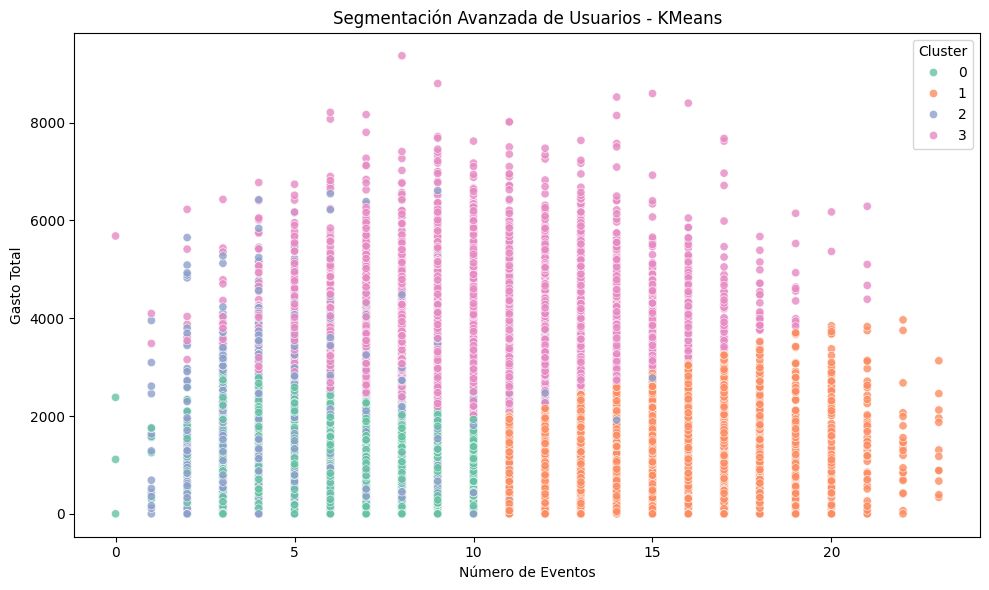

,days_since_last_event,num_events,total_spend,RFM_segment,cluster
user_id,,,,,
1,425.0,8.0,2204.94,low-low-high,0
2,425.0,11.0,0.00,low-medium-low,1
3,424.0,14.0,1878.15,low-high-high,1
4,383.0,6.0,1130.91,high-low-medium,0
5,722.0,1.0,0.00,low-low-low,2


In [ ]:
# Segmentación con KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar features numéricas para clustering
rfm_features = df_segments[['days_since_last_event', 'num_events', 'total_spend']].copy()

# Escalar features para que tengan media=0 y std=1
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Determinar número de clusters (opcional: usar el método del codo)
# Aquí tomamos k=4 como ejemplo
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_segments['cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualización rápida de los clusters
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='num_events',
    y='total_spend',
    hue='cluster',
    data=df_segments,
    palette='Set2',
    alpha=0.8
)
plt.title('Segmentación Avanzada de Usuarios - KMeans')
plt.xlabel('Número de Eventos')
plt.ylabel('Gasto Total')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Ver primeros 5 usuarios con cluster asignado
df_segments[['days_since_last_event','num_events','total_spend','RFM_segment','cluster']].head()


In [ ]:

# Etiquetado de clusters
# Calcular promedio de RFM por cluster para interpretar
cluster_summary = df_segments.groupby('cluster')[['days_since_last_event', 'num_events', 'total_spend']].mean().sort_values('total_spend', ascending=False)
display(cluster_summary)

# Mapear clusters a etiquetas de valor
cluster_labels = {
    cluster_summary.index[0]: 'high-value',
    cluster_summary.index[1]: 'medium-high',
    cluster_summary.index[2]: 'medium-low',
    cluster_summary.index[3]: 'low-value'
}

# Asignar etiquetas al dataframe
df_segments['cluster_label'] = df_segments['cluster'].map(cluster_labels)

# Revisar resultados
df_segments[['days_since_last_event','num_events','total_spend','RFM_segment','cluster','cluster_label']].head(10)


,days_since_last_event,num_events,total_spend
cluster,,,
3,408.604435,10.094800,3329.875863
2,490.253331,7.428703,1388.076033
1,403.234933,13.217504,1029.347169
0,407.078146,7.986755,939.045128


,days_since_last_event,num_events,total_spend,RFM_segment,cluster,cluster_label
user_id,,,,,,
1,425.0,8.0,2204.94,low-low-high,0,low-value
2,425.0,11.0,0.00,low-medium-low,1,medium-low
3,424.0,14.0,1878.15,low-high-high,1,medium-low
4,383.0,6.0,1130.91,high-low-medium,0,low-value
5,722.0,1.0,0.00,low-low-low,2,medium-high
6,403.0,12.0,1782.75,medium-high-medium,1,medium-low
7,384.0,15.0,1258.57,high-high-medium,1,medium-low
8,418.0,7.0,0.00,medium-low-low,0,low-value
9,381.0,16.0,1757.44,high-high-medium,1,medium-low


In [ ]:
# Exportar segmentos

df_segments[['num_events','days_since_last_event','total_spend','purchase_count','RFM_segment','cluster']].to_csv(
    'data/processed/user_segments.csv'
)
print("✅ Segmentos exportados a data/processed/user_segments.csv")